In [1]:
import numpy as np
import scipy
import lightcones.linalg as ll
from lightcones.linalg import kron
from lightcones.models import spinfull_fermions
import lightcones.space as sp
import math

U = 1
t = 0.02

num_iterations = 20

m = 10
l = 3 + 1

E_GND_convergence = []

# iteration 0: preparatory

# left subsystem
# we use [] for list of modes
#        {} for list of states 
# f = [: 3] * [1]

f = spinfull_fermions(l)

H_hopp = sum([sum([- t * (f.a_dag[s][i] @ f.a[s][i - 1] + f.a_dag[s][i - 1] @ f.a[s][i]) for s in range(2)]) for i in range(l)])
H_S = H_hopp + sum([U * f.n[0][i] @ f.n[1][i] for i in range(l)])

# underscore is for
# [: 3] * [1] * [: 3] * [1]
H_S_ = kron(H_S, f.eye)

# for [: 3] * [1]
a_S = f.a[:][-1]
a_S_dag = f.a_dag[:][-1]

# for [: 3] * [1]
a_S_ = kron(a_S, f.eye)
a_S_dag_ = kron(a_S_dag, f.eye)

# right subsystem

# fermion Hamiltonian is always even
H_E_ = kron(f.eye, H_S)

# a and a_dag are odd operators
a_E_ = kron(f.parity, a_S)
a_E_dag_ = kron(f.parity, a_S_dag)

# joint system Hamiltonian
H_SE = H_S_ + H_E_ - sum([t * (a_E_dag_[s] @ a_S_[s] + a_S_dag_[s] @ a_E_[s]) for s in range(2)])

# initial lanczos wavefunction for
# half filled case:
psi0 = np.zeros(f.dimension**2, dtype = complex)
psi0[0] = 1.0
for i in range(l):
    # populate left part
    psi0 = (kron(f.a_dag[0][i], f.eye) + kron(f.a_dag[1][i], f.eye)) @ psi0 / math.sqrt(2.0)
    # popular right part
    psi0 = (kron(f.parity, f.a_dag[0][i]) + kron(f.parity, f.a_dag[1][i])) @ psi0 / math.sqrt(2.0)

print("psi0 norm:")
print(np.vdot(psi0, psi0))

# total occupation of left subsystem:
N_left = sum([sum([f.a_dag[s][i] @ f.a[s][i] for s in range(2)]) for i in range(l)])
N_left_ = kron(N_left, f.eye)

print("psi0 left part occupation:")
print(np.vdot(psi0, N_left_ @ psi0))

# now start regular iterations

dimension_L = f.dimension
parity_L = f.parity
eye_T_ = f.eye

for i in range(num_iterations):

    print("iteration No. ", i)

    # find ground state
    # on iteration 0:
    #   for [: 3] * [1] * [: 3] * [1]
    # on iteration i:
    #   for {: m} * [1] * {: m} * [1]
    
    print("Number of particles in new trial state:")
    print(np.vdot(psi0, (kron(N_left, eye_T_) + kron(eye_T_, N_left)) @ psi0))
    
    # Let us act by H_SE
    Hpsi = H_SE @ H_SE @ psi0
    Hpsi = Hpsi / math.sqrt(np.vdot(Hpsi, Hpsi))
    print("Number of particles in H @ new trial state:")
    print(np.vdot(Hpsi, (kron(N_left, eye_T_) + kron(eye_T_, N_left)) @ Hpsi))
    
    E_GND, Psi_GND = ll.lancz_gnd_state(psi0, H_SE, 10)
    
    print("Number of particles in new ground state:")
    print(np.vdot(Psi_GND, (kron(N_left, eye_T_) + kron(eye_T_, N_left)) @ Psi_GND))
    
    E_GND_convergence.append(E_GND)
    
    print("E_GND = ", E_GND)
    
    print("Psi_GND norm:")
    print(np.vdot(Psi_GND, Psi_GND))
    
    # partial trace
    bp = sp.bipartite(dimension_L, dimension_L)
    # for [: 3] * [1]
    rho = bp.trace_out_R(Psi_GND)
    
    # find eigenvalues sorted in descending order
    pi, T = ll.find_eigs_descending(rho)
    
    print("probability norm:")
    print(sum(pi))
    
    print("Schmidt components:")
    print(pi[:m])
    
    # keep only m largest eigenstates
    # columns are eigenstates
    T = scipy.sparse.csc_matrix(T[:, : m])

    # switch to the frame of revelant eigenstates
    # for {: m}
    T_dag = scipy.sparse.csc_matrix(T.conj().T)
    
    N_left_T = T_dag @ N_left @ T
    
    # for numerical stability:
    # N_left_T has natural numbers as eigenvalues
    N_left_T = N_left_T.rint()
    
    print("Population of Schmidt components:")
    left_N = N_left_T.diagonal().real
    print(left_N)
    
    # we compare population of left subsystem with l + i
    # since we start from l signly occupied sites, and add one electron
    # at each iteration (+ i electrons after i iterations) 
    #assert math.isclose(left_N[0], l + i, rel_tol=1e-7, abs_tol=1e-7), \
    #    "The most important Schmidt component is not at half filling."
    
    H_T = T_dag @ H_S @ T

    mask = np.abs(H_T.data) < 1e-7 
    H_T.data[mask] = 0
    H_T.eliminate_zeros() 
    
    # boundary operators also get renormalized
    # for {: m}
    a_T = [T_dag @ a_S[s] @ T for s in range(2)]
    a_T_dag = [T_dag @ a_S_dag[s] @ T for s in range(2)]

    for s in range(2):
        #
        mask = np.abs(a_T[s].data) < 1e-7 
        a_T[s].data[mask] = 0
        a_T[s].eliminate_zeros()
        #
        mask = np.abs(a_T_dag[s].data) < 1e-7 
        a_T_dag[s].data[mask] = 0
        a_T_dag[s].eliminate_zeros()  

    # new parity operator
    # for {: m}
    parity_T = T_dag @ parity_L @ T
    
    # for numerical stability:
    # parity_T has integers as eigenvalues
    parity_T = parity_T.rint()
    
    eye_T = ll.eye(m)
    
    # add new site
    g = spinfull_fermions(1)
    
    # new boundary operators
    # for {: m} * [1]
    
    # a and a_dag are odd operators
    a_S = kron(parity_T, [g.a[s][0] for s in range(2)])
    a_S_dag = kron(parity_T, [g.a_dag[s][0] for s in range(2)])
    
    a_T_ = kron(a_T, g.eye)
    a_T_dag_ = kron(a_T_dag, g.eye)
    
    # n is even operator
    n_ = kron(eye_T, [g.n[s][0] for s in range(2)])
    
    # 
    H_T_ = kron(H_T, g.eye)
    
    #
    H_S = H_T_ - t * sum([a_S_dag[s] @ a_T_[s] + a_T_dag_[s] @ a_S[s] for s in range(2)]) + U * n_[0] @ n_[1]
    
    eye_T_ = kron(eye_T, g.eye)
    
    # left subsystem
    # for {: m} * [1] * {: m} * [1]
    
    H_S_ = kron(H_S, eye_T_)
    
    a_S_ = kron(a_S, eye_T_)
    a_S_dag_ = kron(a_S_dag, eye_T_)

    # right subsystem
    # for {: m} * [1] * {: m} * [1]

    parity_T_ = kron(parity_T, g.parity)
    
    # fermion Hamiltonian is always even
    H_E_ = kron(eye_T_, H_S)

    # a and a_dag are odd operators
    a_E_ = kron(parity_T_, a_S)
    a_E_dag_ = kron(parity_T_, a_S_dag)
    
    # joint system Hamiltonian
    # for {: m} * [1] * {: m} * [1]

    H_SE = H_S_ + H_E_ - sum([t * (a_E_dag_[s] @ a_S_[s] + a_S_dag_[s] @ a_E_[s]) for s in range(2)])
    
    # update N_left operator
    # add new site
    N_left_ = kron(N_left_T, g.eye) + sum([kron(eye_T, g.n[i][0]) for i in range(2)])
    # embed into left-right system 
    # {: m} * [1] * {: m} * [1]
    #N_left = kron(N_left_, eye_T_)
    N_left = N_left_
    
    # update parity_L
    parity_L = parity_T_
    
    bp_L = sp.bipartite(m, g.dimension)
    
    # update Lanczos initial condition
    # Take the most important Schmidt component |phi_0>
    # with correct number of electrons 
    
    # most significant component in T-representation
    # with correct occupation
    ind = np.where(left_N == l + i)[0][0]
    psi0 = np.zeros(m, dtype = complex)
    psi0[ind] = 1.0
    
    # add one site to the left system.
    # the site wavefunction is at half filling
    psi_g = (g.a_dag[0][0] + g.a_dag[1][0]) @ g.vac() / math.sqrt(2.0)
    
    print("Number of particles in new site:")
    print(np.vdot(psi_g, (g.a_dag[0][0] @ g.a[0][0] + g.a_dag[1][0] @ g.a[1][0]) @ psi_g))
    
    # {: m} * [1]
    psi0_L = bp_L.kron(psi0, psi_g)
    
    print("Number of particles in new left system:")
    print(np.vdot(psi0_L, N_left @ psi0_L))
    
    # joint left * right system
    # {: m} * [1] * {: m} * [1]
    bp_LR = sp.bipartite(bp_L.dimension, bp_L.dimension)
    psi0 = bp_LR.kron(psi0_L, psi0_L)
    
    print("Number of particles in new LR system:")
    print(np.vdot(psi0, (kron(N_left, eye_T_) + kron(eye_T_, N_left)) @ psi0))
    
    dimension_L = bp_L.dimension

ModuleNotFoundError: No module named 'lightcones'

In [7]:
parity_T_.data

array([-1.+0.j, -1.+0.j, -2.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,
        0.+0.j,  0.+0.j, -0.+0.j,  1.-0.j,  1.-0.j,  2.-0.j,  0.-0.j,
       -0.+0.j,  0.-0.j,  0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j,  1.-0.j,
        1.-0.j,  2.-0.j,  0.-0.j, -0.+0.j,  0.-0.j,  0.-0.j, -0.+0.j,
       -0.+0.j,  0.-0.j, -1.+0.j, -1.+0.j, -2.+0.j, -0.+0.j,  0.+0.j,
       -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j,  1.+0.j,
        0.+0.j, -2.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j,  1.-0.j, -1.+0.j, -0.+0.j,  2.-0.j, -0.+0.j, -0.+0.j,
        0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j,  1.-0.j, -1.+0.j, -0.+0.j,
        2.-0.j, -0.+0.j, -0.+0.j,  0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j,
       -1.+0.j,  1.+0.j,  0.+0.j, -2.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,
        0.+0.j,  0.+0.j, -0.+0.j, -2.+0.j,  0.+0.j,  1.+0.j,  1.+0.j,
       -0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,  1.+0.j,  2.-0.j,
       -0.+0.j, -1.+0.j, -1.+0.j,  0.-0.j,  0.-0.j, -0.+0.j,  0.-0.j,
        0.-0.j, -1.+

In [5]:
eye_T.data

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [4]:
N_left.data

array([15.+0.j, 16.+0.j, 16.+0.j, 17.+0.j, 15.+0.j, 16.+0.j, 16.+0.j,
       17.+0.j, 15.+0.j, 16.+0.j, 16.+0.j, 17.+0.j, 15.+0.j, 16.+0.j,
       16.+0.j, 17.+0.j, 15.+0.j,  1.+0.j, 16.+0.j,  1.+0.j, 16.+0.j,
        1.+0.j, 17.+0.j,  1.+0.j, 14.+0.j, 15.+0.j, 15.+0.j, 16.+0.j,
        1.+0.j, 17.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, 18.+0.j,  1.+0.j,
       -1.+0.j,  1.+0.j, 18.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, 19.+0.j,
        1.+0.j, -1.+0.j,  1.+0.j, 17.+0.j,  1.+0.j, 18.+0.j,  1.+0.j,
       18.+0.j,  1.+0.j, 19.+0.j, -1.+0.j, 15.+0.j, -1.+0.j, 16.+0.j,
       -1.+0.j, 16.+0.j, -1.+0.j, 17.+0.j, 15.+0.j, 16.+0.j, 16.+0.j,
       17.+0.j])

In [3]:
eye_T_.data

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [ ]:
np.where(left_N == l + i)[0]

array([0, 1, 6, 7, 8, 9])

In [ ]:
np.rint(N_left_T.diagonal().real)

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

Text(0.5, 0, 'iteration No.')

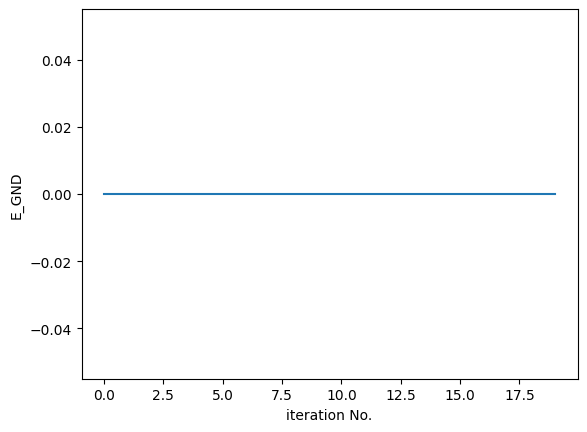

In [2]:
import matplotlib.pyplot as plt
plt.plot(np.array(E_GND_convergence) / (np.array(range(len(E_GND_convergence))) + l))
#plt.plot(np.array(E_GND_convergence))
plt.ylabel(r"E_GND")
plt.xlabel(r"iteration No.")